# 📊 K-Means 聚类算法

> 最经典的聚类算法 - 将数据点分组成K个簇

---

## 📚 学习目标

完成本Notebook后，你将能够：

- ✅ 理解K-Means算法的原理和步骤
- ✅ 从零实现K-Means算法（NumPy版）
- ✅ 使用Scikit-learn的KMeans实现
- ✅ 使用肘部法则确定最佳K值
- ✅ 使用轮廓系数评估聚类质量
- ✅ 可视化聚类结果
- ✅ 理解K-Means的优缺点和适用场景

---

## 1. K-Means 算法原理

### 1.1 核心思想

K-Means是一种**迭代优化算法**，目标是将n个数据点分成k个簇，使得每个数据点属于离它最近的簇中心。

### 1.2 算法步骤

1. **初始化**：随机选择K个数据点作为初始簇中心（centroids）
2. **分配**：将每个数据点分配到最近的簇中心
3. **更新**：重新计算每个簇的中心（簇内所有点的均值）
4. **迭代**：重复步骤2-3，直到簇中心不再变化或达到最大迭代次数

### 1.3 数学公式

**目标函数**（最小化簇内距离平方和）：

$$J = \sum_{i=1}^{K} \sum_{x \in C_i} \|x - \mu_i\|^2$$

其中：
- $K$ 是簇的数量
- $C_i$ 是第i个簇
- $\mu_i$ 是第i个簇的中心
- $\|x - \mu_i\|^2$ 是数据点x到簇中心的欧氏距离的平方

### 1.4 可视化算法过程

```
初始状态:          第1次迭代:         第2次迭代:         收敛:
  •  •  •           •  •  •           •  •  •           •  •  •
    •  •              ●  •              ●  •              ●  •
  •  •                •  ●              •  ●              •  ●
    ●  ●                •  ●              •  ●              •  ●
随机初始中心      分配+更新中心      分配+更新中心      簇中心稳定
```

---

## 2. 环境准备

In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, load_iris
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置随机种子
np.random.seed(42)

print("✅ 环境准备完成！")

✅ 环境准备完成！


## 3. 生成模拟数据

数据形状: (300, 2)
特征范围: X1 [-8.36, 6.03], X2 [-8.26, 10.65]


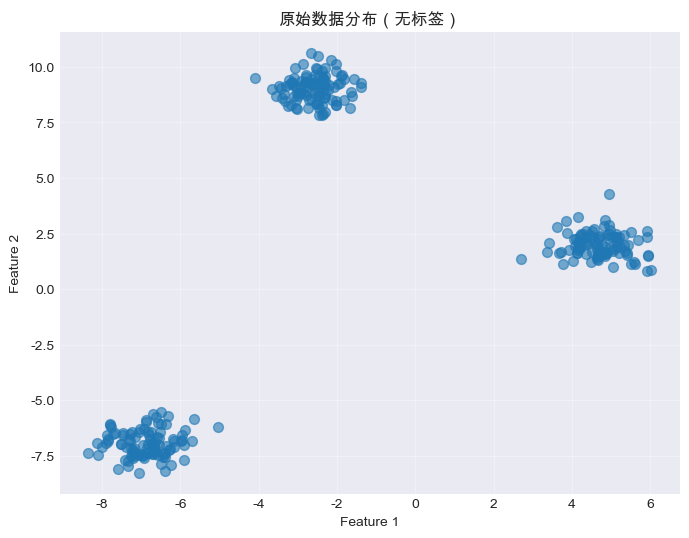

In [2]:
# 生成3个簇的模拟数据
X, y_true = make_blobs(
    n_samples=300,      # 总样本数
    centers=3,          # 簇的数量
    n_features=2,       # 特征数量（2维便于可视化）
    cluster_std=0.6,    # 簇的标准差
    random_state=42
)

print(f"数据形状: {X.shape}")
print(f"特征范围: X1 [{X[:, 0].min():.2f}, {X[:, 0].max():.2f}], X2 [{X[:, 1].min():.2f}, {X[:, 1].max():.2f}]")

# 可视化原始数据（不显示真实标签）
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('原始数据分布（无标签）')
plt.grid(True, alpha=0.3)
plt.show()

## 4. 从零实现 K-Means 算法 ⭐

这是理解算法原理的最佳方式！

In [3]:
class KMeansFromScratch:
    """
    从零实现的K-Means聚类算法
    
    Parameters:
    -----------
    n_clusters : int, default=3
        簇的数量
    max_iters : int, default=100
        最大迭代次数
    tol : float, default=1e-4
        收敛阈值
    """
    
    def __init__(self, n_clusters=3, max_iters=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None  # 簇内距离平方和
        
    def fit(self, X):
        """
        训练K-Means模型
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            训练数据
        """
        # 1. 随机初始化簇中心
        random_idx = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_idx]
        
        for i in range(self.max_iters):
            # 2. 分配：计算每个点到各簇中心的距离，分配到最近的簇
            distances = self._compute_distances(X, self.centroids)
            self.labels_ = np.argmin(distances, axis=1)
            
            # 3. 更新：重新计算每个簇的中心
            new_centroids = np.array([
                X[self.labels_ == k].mean(axis=0) 
                for k in range(self.n_clusters)
            ])
            
            # 4. 检查收敛
            if np.allclose(self.centroids, new_centroids, atol=self.tol):
                print(f"✅ 算法在第 {i+1} 次迭代后收敛")
                break
                
            self.centroids = new_centroids
        
        # 计算惯性（inertia）
        self.inertia_ = self._compute_inertia(X)
        
        return self
    
    def predict(self, X):
        """
        预测新数据点的簇标签
        """
        distances = self._compute_distances(X, self.centroids)
        return np.argmin(distances, axis=1)
    
    def _compute_distances(self, X, centroids):
        """
        计算每个数据点到各簇中心的欧氏距离
        
        Returns:
        --------
        distances : array, shape (n_samples, n_clusters)
        """
        distances = np.zeros((len(X), self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        return distances
    
    def _compute_inertia(self, X):
        """
        计算惯性（簇内距离平方和）
        """
        inertia = 0
        for k in range(self.n_clusters):
            cluster_points = X[self.labels_ == k]
            inertia += np.sum((cluster_points - self.centroids[k]) ** 2)
        return inertia

print("✅ KMeansFromScratch 类定义完成！")

✅ KMeansFromScratch 类定义完成！


In [4]:
# 测试我们从零实现的K-Means
kmeans_scratch = KMeansFromScratch(n_clusters=3, max_iters=100)
kmeans_scratch.fit(X)

print(f"\n簇中心:\n{kmeans_scratch.centroids}")
print(f"\n惯性（Inertia）: {kmeans_scratch.inertia_:.2f}")
print(f"\n每个簇的样本数: {np.bincount(kmeans_scratch.labels_)}")

✅ 算法在第 3 次迭代后收敛

簇中心:
[[-2.58361866  9.03185632]
 [-6.88217395 -6.94243433]
 [ 4.70421356  1.99562444]]

惯性（Inertia）: 204.07

每个簇的样本数: [100 100 100]


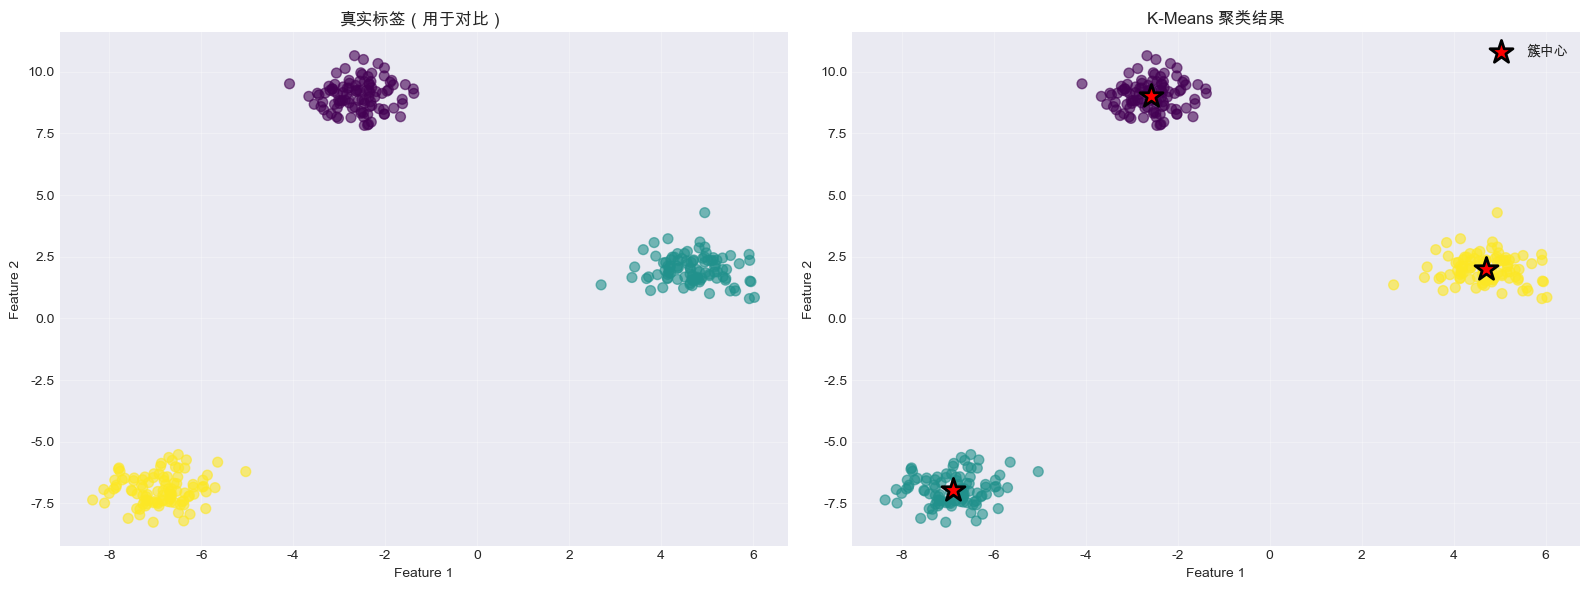

💡 观察：我们的K-Means算法成功地发现了数据中的3个簇！


In [5]:
# 可视化聚类结果
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左图：真实标签
axes[0].scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis', alpha=0.6)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('真实标签（用于对比）')
axes[0].grid(True, alpha=0.3)

# 右图：K-Means聚类结果
axes[1].scatter(X[:, 0], X[:, 1], c=kmeans_scratch.labels_, s=50, cmap='viridis', alpha=0.6)
axes[1].scatter(kmeans_scratch.centroids[:, 0], kmeans_scratch.centroids[:, 1], 
                c='red', s=300, marker='*', edgecolors='black', linewidths=2, label='簇中心')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('K-Means 聚类结果')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 观察：我们的K-Means算法成功地发现了数据中的3个簇！")

## 5. 使用 Scikit-learn 的 K-Means

在实际应用中，我们使用sklearn的优化版本。

In [6]:
# 使用sklearn的KMeans
kmeans_sklearn = KMeans(
    n_clusters=3,           # 簇的数量
    init='k-means++',       # 初始化方法（k-means++更好）
    n_init=10,              # 不同初始化的运行次数
    max_iter=300,           # 最大迭代次数
    random_state=42
)

kmeans_sklearn.fit(X)

print(f"簇中心:\n{kmeans_sklearn.cluster_centers_}")
print(f"\n惯性（Inertia）: {kmeans_sklearn.inertia_:.2f}")
print(f"\n迭代次数: {kmeans_sklearn.n_iter_}")
print(f"\n每个簇的样本数: {np.bincount(kmeans_sklearn.labels_)}")

簇中心:
[[-2.58361866  9.03185632]
 [-6.88217395 -6.94243433]
 [ 4.70421356  1.99562444]]

惯性（Inertia）: 204.07

迭代次数: 2

每个簇的样本数: [100 100 100]


## 6. 确定最佳K值 ⭐⭐⭐

### 6.1 肘部法则 (Elbow Method)

绘制K值与惯性（inertia）的关系，寻找"肘部"（拐点）。

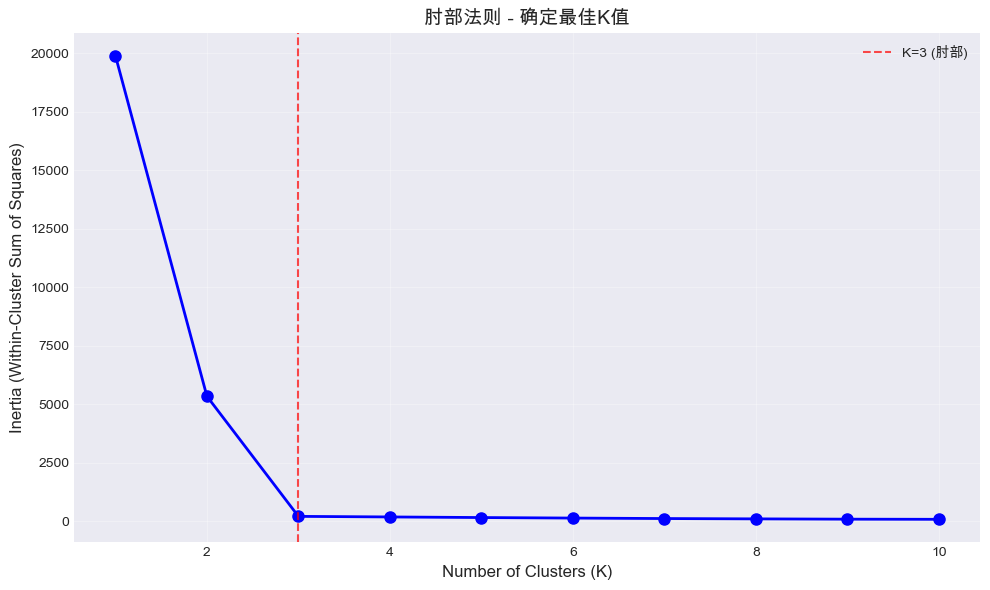

💡 观察：在K=3处出现明显的'肘部'，表明3个簇是最佳选择。
   K>3后，惯性下降速度明显变慢。


In [7]:
# 测试不同的K值
K_range = range(1, 11)
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('肘部法则 - 确定最佳K值', fontsize=14)
plt.grid(True, alpha=0.3)

# 标记K=3的位置
plt.axvline(x=3, color='r', linestyle='--', alpha=0.7, label='K=3 (肘部)')
plt.legend()

plt.tight_layout()
plt.show()

print("💡 观察：在K=3处出现明显的'肘部'，表明3个簇是最佳选择。")
print("   K>3后，惯性下降速度明显变慢。")

### 6.2 轮廓系数 (Silhouette Score)

**轮廓系数**衡量聚类的质量，范围在 [-1, 1]：
- 接近 +1：样本离自己的簇很近，离其他簇很远（好）
- 接近 0：样本在两个簇的边界上
- 接近 -1：样本可能被分配到错误的簇（差）

K=2: Silhouette Score = 0.7361
K=3: Silhouette Score = 0.9084
K=4: Silhouette Score = 0.7042
K=5: Silhouette Score = 0.5177
K=6: Silhouette Score = 0.3268
K=7: Silhouette Score = 0.3573
K=8: Silhouette Score = 0.3666
K=9: Silhouette Score = 0.3686
K=10: Silhouette Score = 0.3568


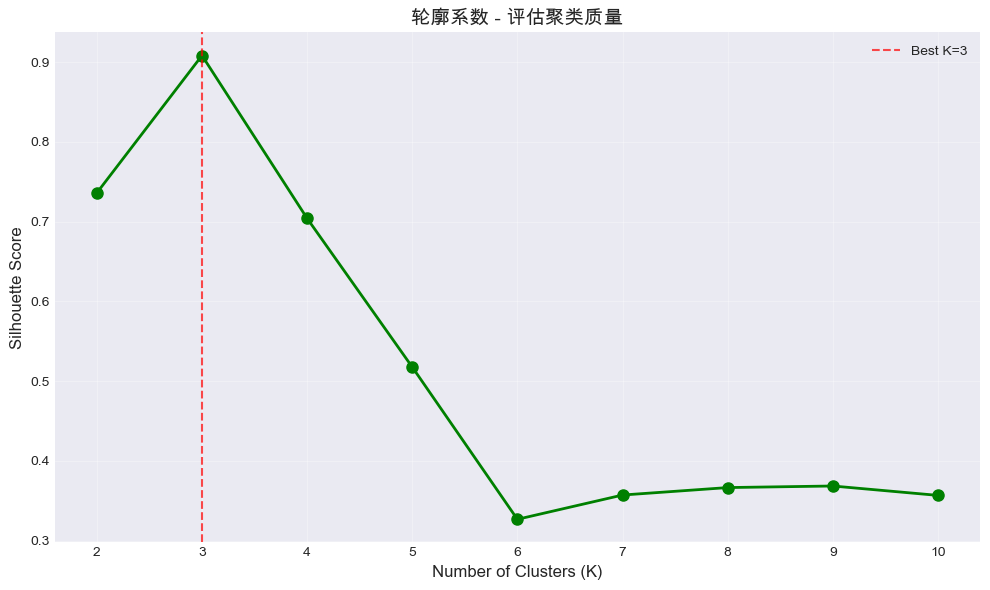


💡 最佳K值: 3 (轮廓系数最高)


In [8]:
# 计算不同K值的轮廓系数
K_range = range(2, 11)  # 轮廓系数要求K>=2
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.4f}")

# 绘制轮廓系数图
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('轮廓系数 - 评估聚类质量', fontsize=14)
plt.grid(True, alpha=0.3)

# 标记最佳K值
best_k = K_range[np.argmax(silhouette_scores)]
plt.axvline(x=best_k, color='r', linestyle='--', alpha=0.7, label=f'Best K={best_k}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n💡 最佳K值: {best_k} (轮廓系数最高)")

### 6.3 其他评估指标

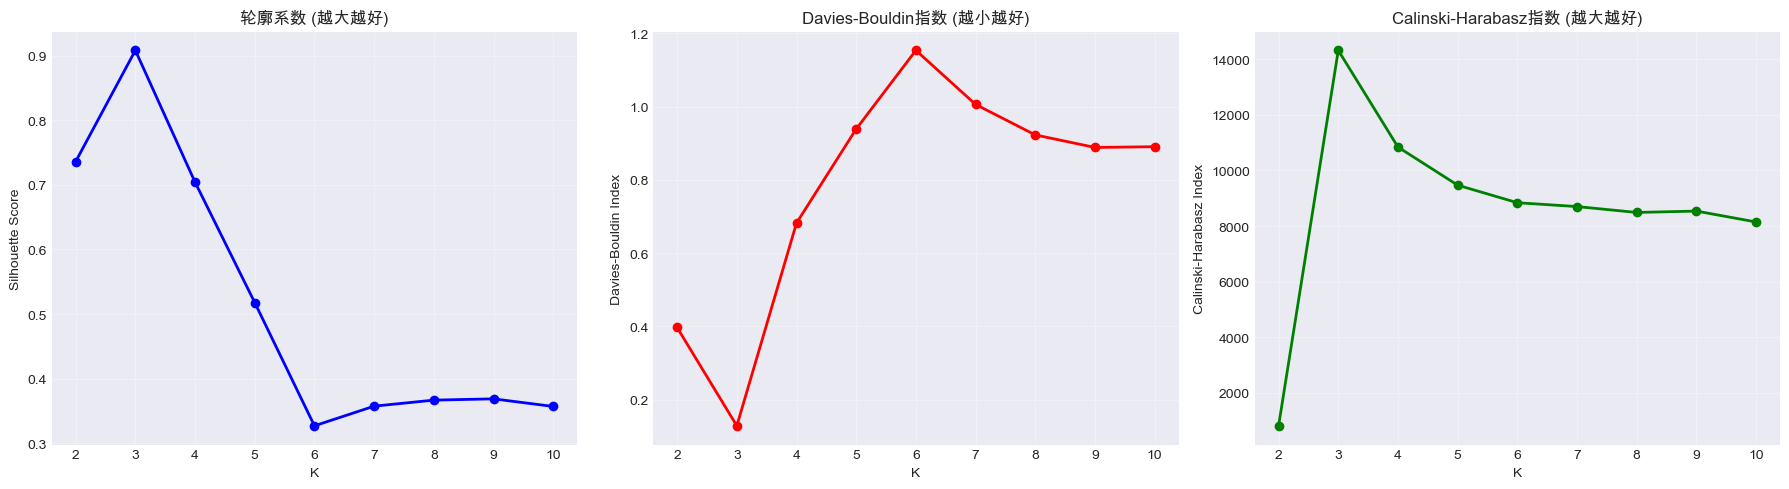

💡 三个指标都指向K=3是最佳选择！


In [9]:
# 计算多种评估指标
K_range = range(2, 11)
metrics = {
    'Silhouette': [],
    'Davies-Bouldin': [],  # 越小越好
    'Calinski-Harabasz': []  # 越大越好
}

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    metrics['Silhouette'].append(silhouette_score(X, labels))
    metrics['Davies-Bouldin'].append(davies_bouldin_score(X, labels))
    metrics['Calinski-Harabasz'].append(calinski_harabasz_score(X, labels))

# 绘制对比图
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(K_range, metrics['Silhouette'], 'bo-', linewidth=2)
axes[0].set_xlabel('K')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('轮廓系数 (越大越好)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, metrics['Davies-Bouldin'], 'ro-', linewidth=2)
axes[1].set_xlabel('K')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin指数 (越小越好)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(K_range, metrics['Calinski-Harabasz'], 'go-', linewidth=2)
axes[2].set_xlabel('K')
axes[2].set_ylabel('Calinski-Harabasz Index')
axes[2].set_title('Calinski-Harabasz指数 (越大越好)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 三个指标都指向K=3是最佳选择！")

## 7. 真实数据集实战 - Iris 鸢尾花数据集

In [10]:
# 加载Iris数据集
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names

print(f"数据形状: {X_iris.shape}")
print(f"特征名称: {feature_names}")
print(f"类别名称: {iris.target_names}")

# 数据标准化（重要！）
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

print("\n✅ 数据已标准化")

数据形状: (150, 4)
特征名称: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
类别名称: ['setosa' 'versicolor' 'virginica']

✅ 数据已标准化


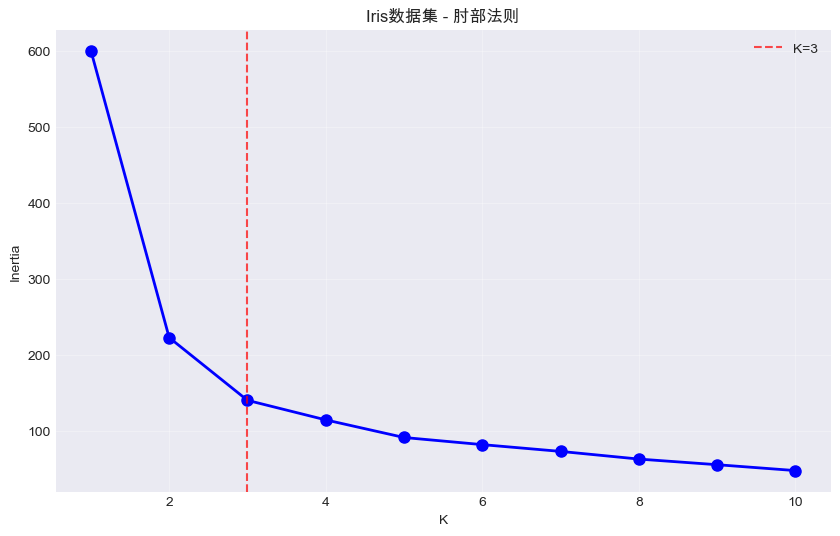

In [11]:
# 使用肘部法则确定最佳K值
K_range = range(1, 11)
inertias_iris = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_iris_scaled)
    inertias_iris.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias_iris, 'bo-', linewidth=2, markersize=8)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Iris数据集 - 肘部法则')
plt.axvline(x=3, color='r', linestyle='--', alpha=0.7, label='K=3')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# 使用K=3进行聚类
kmeans_iris = KMeans(n_clusters=3, random_state=42, n_init=10)
y_pred = kmeans_iris.fit_predict(X_iris_scaled)

# 评估聚类质量
print(f"轮廓系数: {silhouette_score(X_iris_scaled, y_pred):.4f}")
print(f"Davies-Bouldin指数: {davies_bouldin_score(X_iris_scaled, y_pred):.4f}")
print(f"Calinski-Harabasz指数: {calinski_harabasz_score(X_iris_scaled, y_pred):.4f}")

# 查看每个簇的样本数
print(f"\n每个簇的样本数: {np.bincount(y_pred)}")
print(f"真实类别的样本数: {np.bincount(y_iris)}")

轮廓系数: 0.4599
Davies-Bouldin指数: 0.8336
Calinski-Harabasz指数: 241.9044

每个簇的样本数: [53 50 47]
真实类别的样本数: [50 50 50]


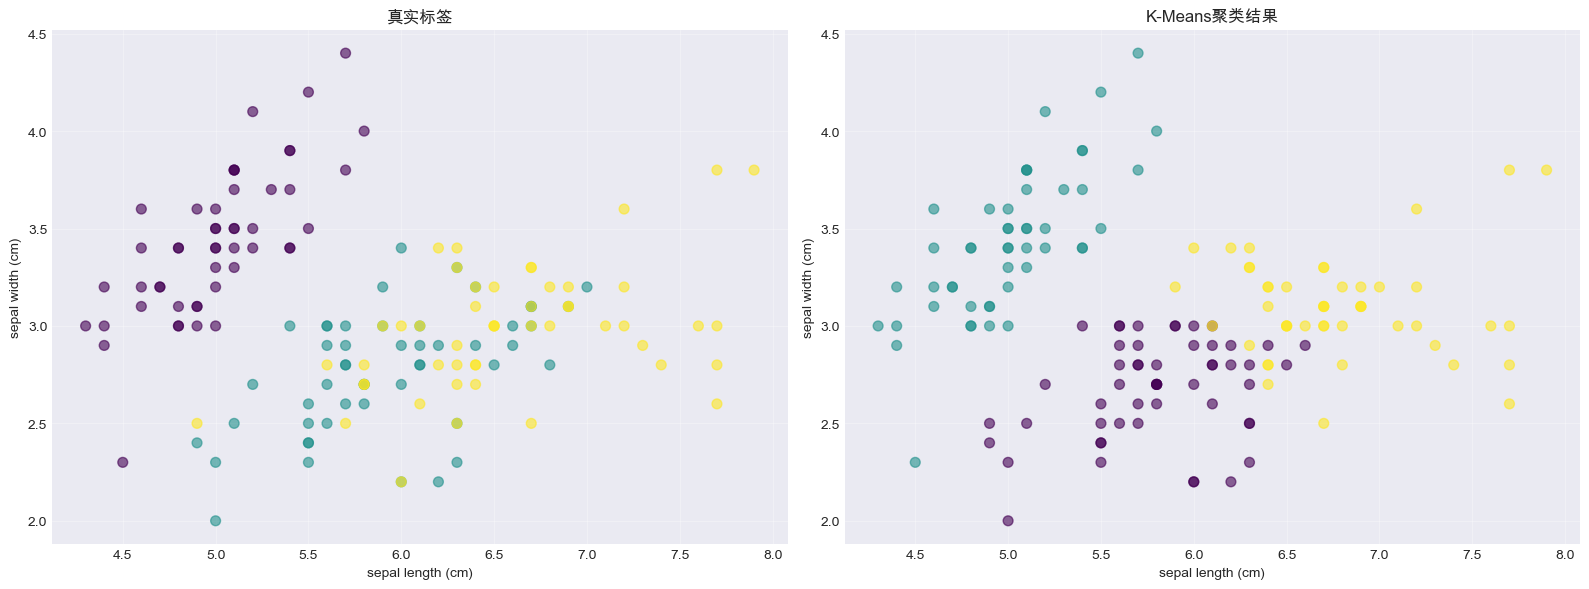

💡 观察：K-Means的聚类结果与真实标签高度一致！


In [13]:
# 可视化聚类结果（使用前2个特征）
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 真实标签
axes[0].scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, s=50, cmap='viridis', alpha=0.6)
axes[0].set_xlabel(feature_names[0])
axes[0].set_ylabel(feature_names[1])
axes[0].set_title('真实标签')
axes[0].grid(True, alpha=0.3)

# K-Means聚类结果
axes[1].scatter(X_iris[:, 0], X_iris[:, 1], c=y_pred, s=50, cmap='viridis', alpha=0.6)
axes[1].set_xlabel(feature_names[0])
axes[1].set_ylabel(feature_names[1])
axes[1].set_title('K-Means聚类结果')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 观察：K-Means的聚类结果与真实标签高度一致！")

## 8. K-Means 的优缺点

### ✅ 优点

1. **简单易懂**：算法直观，易于实现
2. **计算高效**：时间复杂度 O(n·k·i·d)
   - n: 样本数
   - k: 簇数
   - i: 迭代次数
   - d: 特征维度
3. **可扩展性好**：适用于大规模数据集
4. **收敛速度快**：通常几次迭代就能收敛

### ❌ 缺点

1. **需要预先指定K值**：不知道K值时需要使用肘部法则等方法
2. **对初始值敏感**：不同的初始簇中心可能导致不同结果
   - 解决方案：k-means++初始化、多次运行取最佳
3. **只能发现球形簇**：假设簇是凸形且大小相似
4. **对异常值敏感**：异常值会影响簇中心的计算
5. **受特征尺度影响**：需要数据标准化

### 🎯 适用场景

- 客户分群
- 图像分割
- 文档聚类
- 异常检测（预处理）
- 特征工程（聚类特征）

### 🚫 不适用场景

- 非球形簇（使用DBSCAN）
- 簇大小差异很大
- 有大量噪声点
- 不知道K值且难以确定

---

## 9. 练习题

### 练习1：理解K-Means初始化的重要性

运行K-Means多次，观察不同初始化的影响。

In [ ]:
# TODO: 你的代码
# 提示：设置n_init=1，用不同的random_state运行多次，对比inertia

# 示例：
# for seed in range(5):
#     kmeans = KMeans(n_clusters=3, n_init=1, random_state=seed)
#     kmeans.fit(X)
#     print(f"Seed {seed}: Inertia = {kmeans.inertia_:.2f}")

### 练习2：数据标准化的重要性

对比标准化前后的聚类结果。

In [ ]:
# TODO: 你的代码
# 提示：
# 1. 创建一个特征尺度差异很大的数据集
# 2. 分别对原始数据和标准化后的数据进行聚类
# 3. 对比轮廓系数

### 练习3：K-Means 在非球形簇上的局限性

生成月牙形或环形数据，观察K-Means的表现。

In [ ]:
# TODO: 你的代码
# 提示：使用 sklearn.datasets.make_moons 或 make_circles

# from sklearn.datasets import make_moons
# X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=42)
# ...

## 10. 小结

### 🎯 本节要点

1. **K-Means算法**是最经典的聚类算法
2. **算法步骤**：初始化 → 分配 → 更新 → 迭代
3. **确定K值**：肘部法则 + 轮廓系数
4. **评估指标**：轮廓系数、Davies-Bouldin指数、Calinski-Harabasz指数
5. **数据预处理**：标准化很重要！
6. **初始化方法**：k-means++ 优于随机初始化
7. **局限性**：只能发现球形簇、对异常值敏感

### ✅ 检查清单

- [ ] 理解K-Means算法的数学原理
- [ ] 能从零实现K-Means
- [ ] 会使用sklearn.cluster.KMeans
- [ ] 会使用肘部法则确定K值
- [ ] 会使用轮廓系数评估聚类质量
- [ ] 理解K-Means的优缺点和适用场景
- [ ] 完成3个练习题

### 🚀 下一步

继续学习 `02_dbscan_hierarchical.ipynb` - 密度聚类和层次聚类

---

**💪 做得好！你已经掌握了K-Means聚类算法！**